In [29]:
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-ug2vz7bi
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-ug2vz7bi
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done


## Setup and installations


In [30]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from coutils import fix_random_seed, rel_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [31]:
dtype = torch.float
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [32]:
# the show_images function displays a set of images in a grid layout. 
# The input images should be a PyTorch Tensor of shape (N, C, H, W) where N is the number of images,
# C is the number of channels, and H and W are the height and width of the images.
# The function returns a grid of images as a PyTorch Tensor, with shape (1, C, H * sqrt(N), W * sqrt(N))
# where C * H * W == number of features in image
# and sqrt(N) * sqrt(N) == number of images
def show_images(images):
  images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
  sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
  sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(sqrtn, sqrtn))
  gs = gridspec.GridSpec(sqrtn, sqrtn)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([sqrtimg,sqrtimg]))
  return 

# the count_params function computes the number of parameters in the model
# inputs: model - a PyTorch nn.Module
# returns: num_params - the number of parameters in the model
def count_params(model):
  """Count the number of parameters in the model"""
  param_count = sum([p.numel() for p in model.parameters()])
  return param_count

answers = {}

answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)
answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)

## Flatten

We provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [33]:
# the Flatten class flattens the incoming tensor into a matrix
class Flatten(nn.Module):
  # the forward function takes in a Tensor of shape (N, C, H, W)
  # and returns a Tensor of shape (N, C*H*W)
  def forward(self, x):
    N, C, H, W = x.size() # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# the Unflatten class reshapes a flattened incoming tensor
# into a Tensor of shape (N, C, H, W)
# this is the exact opposite of the Flatten module
class Unflatten(nn.Module):
  # the constructor takes in the desired output shape
  # and passes it to the parent constructor
  def __init__(self, N=-1, C=128, H=7, W=7):
    super(Unflatten, self).__init__()
    self.N = N
    self.C = C
    self.H = H
    self.W = W
  
  # the forward function reshapes the incoming Tensor
  def forward(self, x):
    return x.view(self.N, self.C, self.H, self.W)

# the initialize_weights function initializes the weights of the model
def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    init.xavier_uniform_(m.weight.data)

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

We will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

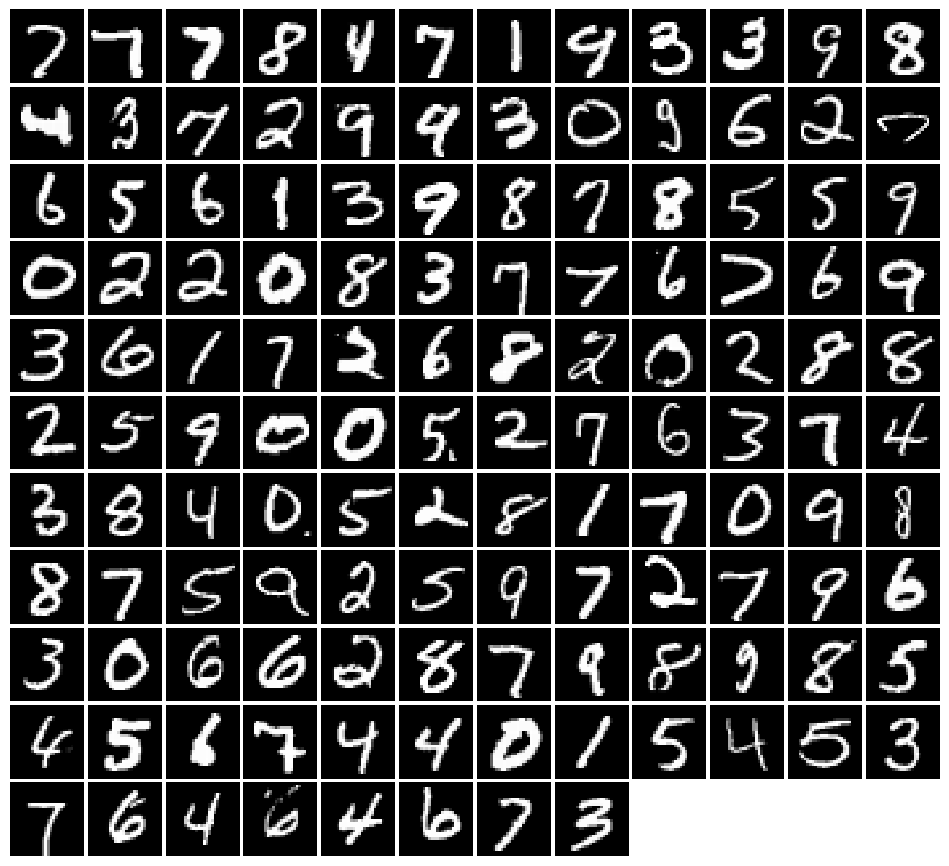

In [34]:
NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

# Iterate over data loader to get a batch of images
for batch in loader_train:
    imgs = batch[0].view(batch_size, 784)
    show_images(imgs)
    break  # Stop after first batch for demonstration

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [35]:
# the sample_noise function generates a PyTorch Tensor of uniform random noise.
def sample_noise(batch_size, dim, dtype=torch.float, device='cpu'):
  return 2 * torch.rand((batch_size, dim), device = device, dtype = dtype) - 1

# Discriminator
Our first step is to build a discriminator.

In [36]:
def discriminator():
  # the model should consist of a fully connected layer with input size 784
  # and output size 256. LeakyReLU with alpha 0.01 should be used.
  # Next, another fully connected layer with output size 256 followed by a
  # LeakyReLU with alpha 0.01 should be used. Finally, a linear layer
  # with output size 1 should be used.
  model = nn.Sequential(
    Flatten(),
    nn.Linear(784,  256),
    nn.LeakyReLU(0.01),
    nn.Linear(256,  256),
    nn.LeakyReLU(0.01),
    nn.Linear(256,  1),
  )
  return model

# Generator

In [37]:
def generator(noise_dim=NOISE_DIM):
  # the model should consist of a fully connected layer with input size equal to
  # noise_dim and output size 1024. Next, a ReLU and another fully connected layer
  # with output size 1024 should be added. ReLU should be used as the activation.
  # Finally, a fully connected layer with output size 784 followed by a TanH
  model = nn.Sequential(
    nn.Linear(noise_dim,  1024),
    nn.ReLU(),
    nn.Linear(1024,  1024),
    nn.ReLU(),
    nn.Linear(1024,  784),
    nn.Tanh(),
  )
  return model

# GAN Loss

In [38]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

In [39]:
# the discriminator_loss function takes in the discriminator predictions
# for real and fake images and returns the total loss.
# For the discriminator, the total loss is the sum of the losses for real
# and fake images, d_loss_real and d_loss_fake, respectively.
def discriminator_loss(logits_real, logits_fake):
  loss = None
  N = logits_real.shape[0]
  loss = torch.mean(bce_loss(logits_real, torch.ones_like(logits_real)) + 
        bce_loss(logits_fake, torch.zeros_like(logits_fake)))

  return loss

# the generator_loss function also takes in the discriminator predictions
# for fake images. The generator loss is similar but with labels flipped.
def generator_loss(logits_fake):
  loss = None
  true_labels = torch.ones_like(logits_fake)
  loss = bce_loss(logits_fake, true_labels)

  return loss

# Optimizing our loss

In [40]:
# the get_optimizer function sets up the optimizer for the model.
# The optimizer should be an Adam with betas (0.5, 0.999).
def get_optimizer(model):
  optimizer = None
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3, betas=(0.5, 0.999))
  return optimizer

# Training a GAN!

In [41]:
# training our GAN!
# the run_a_gan function trains a GAN for a given number of epochs and
# returns a tuple of the generator and discriminator.
# the inputs are all PyTorch tensors.
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.to(device)
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1

Iter: 0, D: 1.37, G:0.6852


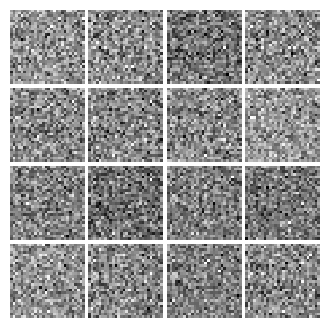


Iter: 250, D: 1.929, G:0.5477


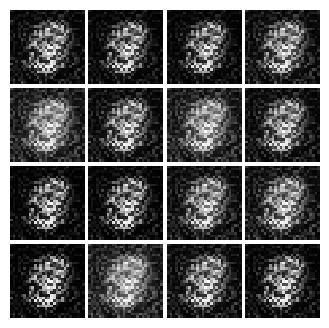


Iter: 500, D: 1.204, G:1.058


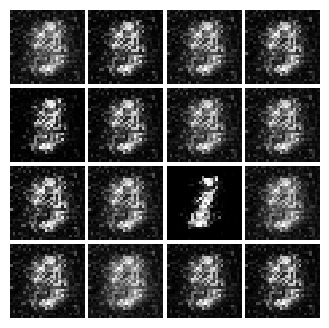


Iter: 750, D: 1.111, G:0.8215


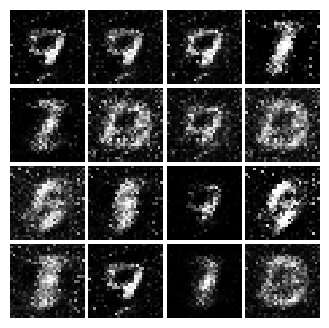


Iter: 1000, D: 1.302, G:1.002


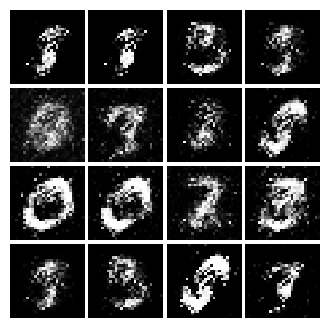


Iter: 1250, D: 1.337, G:1.192


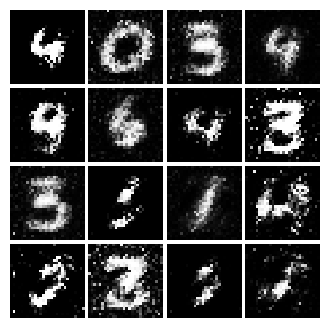


Iter: 1500, D: 1.331, G:0.8631


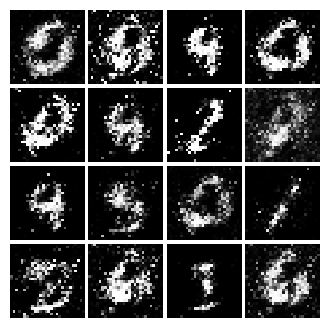


Iter: 1750, D: 1.353, G:0.8365


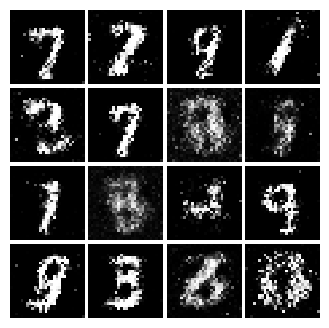


Iter: 2000, D: 1.234, G:0.7883


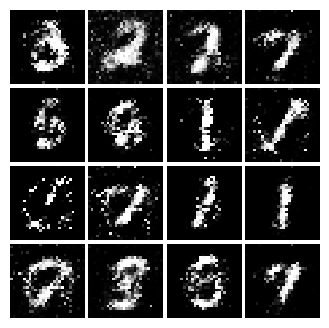


Iter: 2250, D: 1.242, G:0.8994


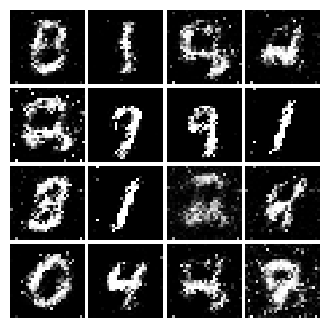


Iter: 2500, D: 1.389, G:0.8514


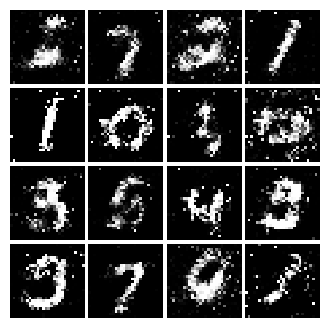


Iter: 2750, D: 1.363, G:0.8868


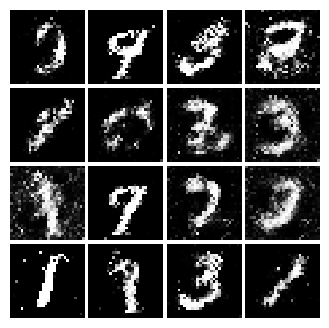


Iter: 3000, D: 1.338, G:0.8132


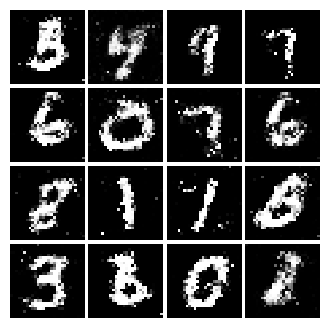


Iter: 3250, D: 1.323, G:0.8455


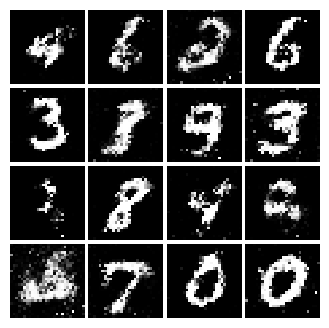


Iter: 3500, D: 1.305, G:0.7958


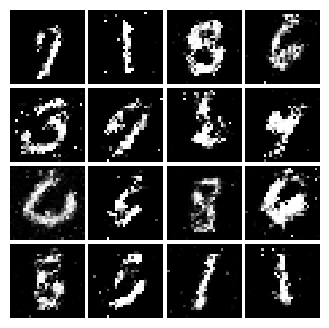


Iter: 3750, D: 1.279, G:0.7783


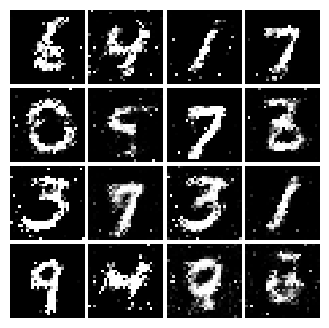


Iter: 4000, D: 1.324, G:0.7888


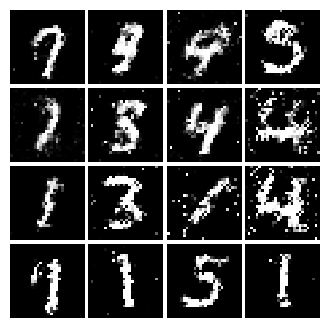


Iter: 4250, D: 1.335, G:0.7803


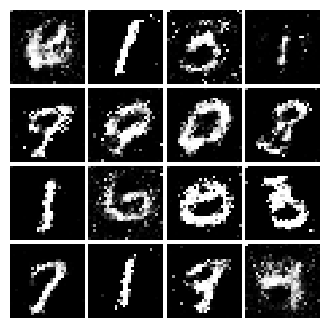


Iter: 4500, D: 1.336, G:0.7731


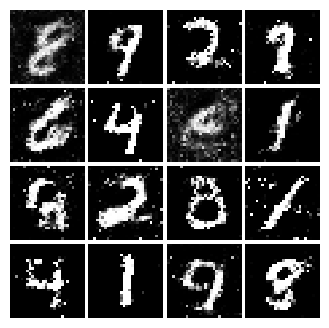

In [42]:
fix_random_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generator
G = generator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Deeply Convolutional GANs
In the first part, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks.

#### Discriminator

In [43]:
# the build_dc_classifier function build and return a PyTorch model for the DCGAN discriminator implementing the architecture above.
def build_dc_classifier():
  # the model should contain:
  # 2d convolutional layer with 32 filters, 4x4 kernel size, stride 2, and padding 1
  # leaky relu with slope 0.01
  # 2d convolutional layer with 64 filters, 4x4 kernel size, stride 2, and padding 1
  # leaky relu with slope 0.01
  # flatten layer
  # linear layer with output size 1024
  # leaky relu with slope 0.01
  # linear layer with output size 1
  return nn.Sequential(
    Unflatten(N=-1, C=1, H=28, W=28),
    nn.Conv2d(1, 32, 5, 1),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5, 1),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(2, 2),
    Flatten(),
    nn.Linear(1024,   4 * 4 * 64),
    nn.LeakyReLU(0.01),
    nn.Linear(4 * 4 * 64,   1),
  )

data = next(enumerate(loader_train))[-1][0].to(dtype=dtype, device=device)
batch_size = data.size(0)
b = build_dc_classifier().to(device)
out = b(data)
print(out.size())

torch.Size([128, 1])


In [44]:
def test_dc_classifer(true_count=1102721):
  model = build_dc_classifier()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_classifer()

1102721
Correct number of parameters in generator.


#### Generator

In [45]:
# the build_dc_generator function build and return a PyTorch model for the DCGAN generator implementing the architecture above.
def build_dc_generator(noise_dim=NOISE_DIM):
  return nn.Sequential(
    nn.Linear(noise_dim, 1024),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 7 * 7 * 128),
    nn.ReLU(),
    nn.BatchNorm1d(7 * 7 * 128),
    Unflatten(N=-1, C=128, H=7, W=7),
    nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, 4, stride = 2, padding = 1),
    nn.Tanh(),
    Flatten(),
  )

test_g_gan = build_dc_generator().to(device)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, dtype=dtype, device=device)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

In [46]:
def test_dc_generator(true_count=6580801):
  model = build_dc_generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_generator()

6580801
Correct number of parameters in generator.


Iter: 0, D: 1.381, G:0.9584


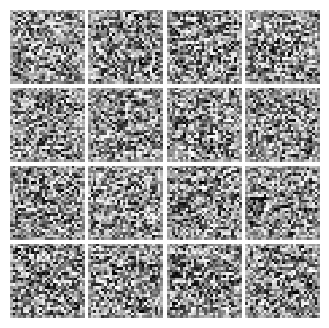


Iter: 250, D: 1.16, G:0.8205


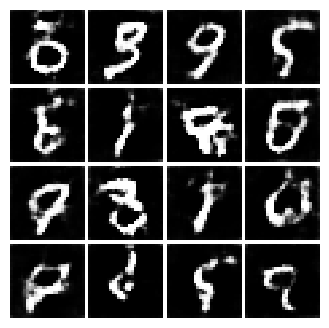


Iter: 500, D: 1.155, G:0.6453


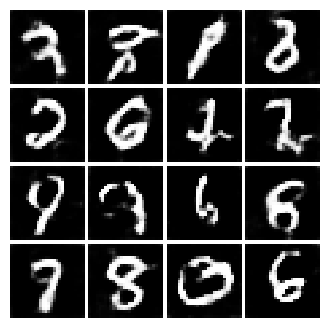


Iter: 750, D: 1.092, G:1.669


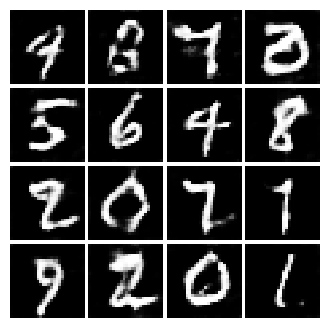


Iter: 1000, D: 1.039, G:1.408


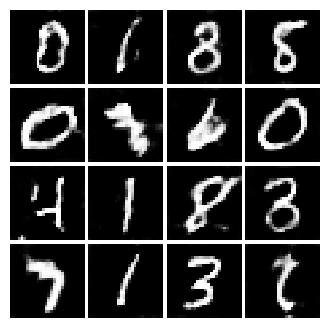


Iter: 1250, D: 1.149, G:1.396


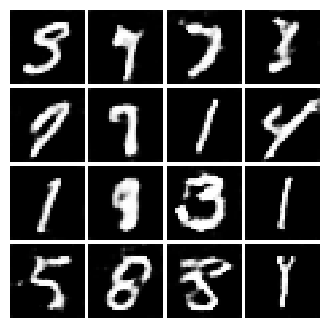


Iter: 1500, D: 0.9791, G:1.859


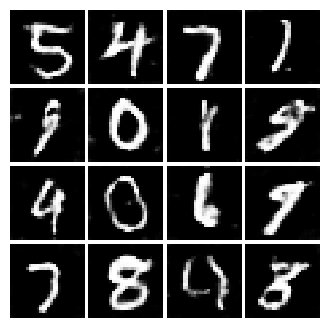


Iter: 1750, D: 0.9087, G:1.384


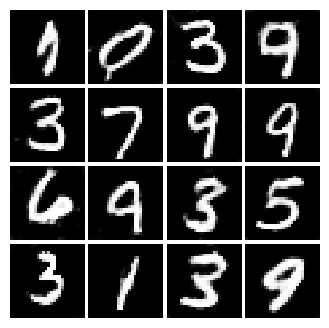


Iter: 2000, D: 1.355, G:2.916


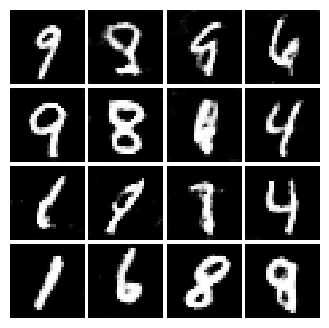


Iter: 2250, D: 0.8283, G:1.371


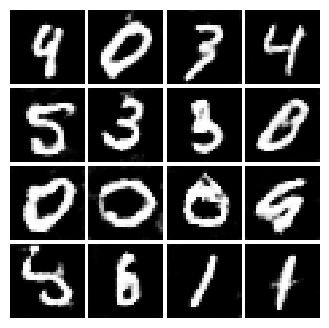

In [47]:
fix_random_seed(0)

D_DC = build_dc_classifier().to(device) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().to(device)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)